# A neural network-based classifier for the MNIST handwritten digit dataset (Attempt 2)

Let's start by importing some packages we need.

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.cmap'] = 'Greys'

import numpy as np
np.set_printoptions(suppress=True)
np.set_printoptions(precision=2)

## Getting a feel for the data

MNIST is a dataset that contains 70,000 labelled images of handwritten digits that look like the following.

![MNIST Data Sample](images/mnist-sample.png "MNIST Data Sample")

We're going to train a linear classifier on a part of this data set, and test it against another portion of the data set to see how well we did.

The TensorFlow tutorial comes with a handy loader for this dataset.

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The loader even handily splits the data set into three parts:

* A training set (55000 examples) used to train the model
* A validation set (5000 examples) used to optimise hyperparameters (not shown today)
* A test set (10000 examples) used to gauge the accuracy of the trained model

The images are greyscale and each 28 pixels wide by 28 pixels tall, and this is stored as an array of length 784.

The labels are a *one hot* vector of length 10, meaning it is a vector of all zeros except at the location that corresponds to the label it's referring to. E.g. An image with a label `3` will be represented as `(0, 0, 0, 1, 0, 0, 0, 0, 0, 0)`.


In [3]:
print mnist.train.images.shape
print mnist.train.labels.shape

(55000, 784)
(55000, 10)


In [4]:
print mnist.test.images.shape
print mnist.test.labels.shape

(10000, 784)
(10000, 10)


We can get a better sense for one of these examples by visualising the image and looking at the label.

[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


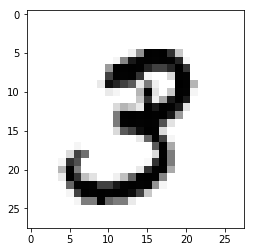

In [5]:
example_image = mnist.train.images[1]
example_image_reshaped = example_image.reshape((28, 28)) # Can't render a line of 784 numbers
example_label = mnist.train.labels[1]

print example_label
plt.imshow(example_image_reshaped)

## Setting up a score function, loss function and optimisation algorithm

Now that we have a better sense of the dataset we're working with, let's move onto the machine learning bits.

First, we setup some placeholders to hold batches of this training data for when we learn our model. The reason why we work in batches is that it's easier on memory than holding the entire set. And it's this notion of working with (random) batches of input rather than the entire set that moves us from the realm of *Gradient Descent* that we saw earlier, to *Stochastic Gradient Descent* that we have here.

In [6]:
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

We define a nonlinear model for the score function (a vanilla neural network) after introducing two sets of parameters, **W1**, **b1** and **W2**, **b2**.

![Neural network 1 hidden layer](images/neural-network-1-hidden.png "Neural network with 1 hidden layer")

In [7]:
W1 = tf.Variable(tf.truncated_normal(shape=[784, 100], stddev=0.1))
b1 = tf.Variable(tf.constant(0.1, shape=[100]))
h1 = tf.nn.relu(tf.matmul(x, W1) + b1)

W2 = tf.Variable(tf.truncated_normal(shape=[100, 10], stddev=0.1))
b2 = tf.Variable(tf.constant(0.1, shape=[10]))
y = tf.nn.softmax(tf.matmul(h1, W2) + b2)

Recall that this initialisation was previously flawed because of starting with zeros as below:

````
W1 = tf.Variable(tf.zeros([784, 100]))
b1 = tf.Variable(tf.zeros([100]))
W2 = tf.Variable(tf.zeros([100, 10]))
b2 = tf.Variable(tf.zeros([10]))

````

We define our loss function to measure how poorly this model performs on images with known labels. We use the a specific form called the [cross entropy loss](https://jamesmccaffrey.wordpress.com/2013/11/05/why-you-should-use-cross-entropy-error-instead-of-classification-error-or-mean-squared-error-for-neural-network-classifier-training/).

In [8]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_*tf.log(y), reduction_indices=[1]))

Using the magic of blackbox optimisation algorithms provided by TensorFlow, we can define a single step of the stochastic gradient descent optimiser (to improve our parameters for our score function and reduce the loss) in one line of code.

In [9]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

## Training the model

The way TensorFlow works, we haven't really executed any of the code above in the classic sense. All we've done is defined what's called the computational graph.

Now we go ahead and initialise a session to actually train the model and evaluate its performance.

In [10]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

We train the model iteratively for 1000 steps, loading a batch of example images each time.

In [11]:
for i in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

## Verifying the results

At this point, our model is trained. And we can deterime in the *accuracy* by passing in all the test images and labels, figuring out our own labels, and averaging out the results.

In [12]:
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9654


Around 96%! Amazing.

## Extensions

1. Play around with the length of the hidden layer and see how the accuracy changes.

2. Try extending the model to two hidden layers and see how much the accuracy increases:

  ![Neural network 2 hidden layer](images/neural-network-2-hidden.png "Neural network with 2 hidden layer")
    
  ````
  W1 = tf.Variable(tf.truncated_normal(shape=[784, 400], stddev=0.1))
  b1 = tf.Variable(tf.constant(0.1, shape=[400]))
  h1 = tf.nn.relu(tf.matmul(x, W1) + b1)
  
  W2 = tf.Variable(tf.truncated_normal(shape=[400, 100], stddev=0.1))
  b2 = tf.Variable(tf.constant(0.1, shape=[100]))
  h2 = tf.nn.relu(tf.matmul(h1, W2) + b2)
  
  W3 = tf.Variable(tf.truncated_normal(shape=[100, 10], stddev=0.1))
  b3 = tf.Variable(tf.constant(0.1, shape=[10]))
  y = tf.nn.softmax(tf.matmul(h2, W3) + b3)
  
  ````

3. Do you have a sense for how many parameters we're approximating and how they're growing as we add these layers?

4. How would you improve the accuracy even further?